In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras 
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, CuDNNLSTM, Flatten
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, Input, LeakyReLU, ConvLSTM2D, Conv2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
from numpy import pi
import tensorflow as tf
import tensorflow.python.keras.backend as K

Populating the interactive namespace from numpy and matplotlib


# Data Generation

In [2]:
class Particle_Tracking_Training_Data(tf.Module):
    def __init__(self, Nt, rings=True):
        self.Nt = int(Nt)
        self.Ny = self.Nx = 256
        self.d = 3
        ximg = [[[i, j] for i in np.arange(self.Ny)]
            for j in np.arange(self.Nx)]
        self.ximg = np.float32(ximg)

        x = np.arange(self.Nx) - self.Nx//2
        y = np.arange(self.Ny) - self.Ny//2
        X0, Y0 = np.meshgrid(x, y)
        self.X = np.float32(X0)
        self.Y = np.float32(Y0)

        if rings:
            self.ring_indicator = 1.
        else:
            self.ring_indicator = 0.

        self._gen_video = tf.function(
            input_signature=(
                tf.TensorSpec(
                    shape=[self.Ny, self.Nx, self.Nt, None], dtype=tf.float32),
                tf.TensorSpec(shape=[self.Nt, None], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.float32),)
        )(self._gen_video)

        self._gen_labels = tf.function(
            input_signature=(
                tf.TensorSpec(
                    shape=[self.Ny, self.Nx, self.Nt, None], dtype=tf.float32),)
        )(self._gen_labels)

    def __call__(self, kappa, a, IbackLevel, Nparticles, sigma_motion):
        ## random brownian motion paths
        ## Nt, Nparticles, 3
        xi = self._sample_motion(Nparticles, sigma_motion)

        #### translate track positions to img coords
        ## Ny, Nx, Nt, Np, 2
        XALL = (self.ximg[:, :, None, None, :]
                - xi[None, None, :, :, :2])
        ## Ny, Nx, Nt, Np
        r = tf.math.sqrt(XALL[..., 0]**2 + XALL[..., 1]**2)
        z = xi[..., 2]

        ### generate video
        I = self._gen_video(r, z, kappa, a, IbackLevel)

        ### generate labels
        labels = self._gen_labels(r)

        return I, labels, xi

    @staticmethod
    def rand(n):
        return tf.random.uniform([n], dtype=tf.float32)

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),))
    def _sample_motion(self, Nparticles, sigma_motion):
        #### boundaries
        b_lower = tf.constant(
            [-10, -10, -30.], tf.float32)
        b_upper = tf.constant(
            [self.Nx+10, self.Ny+10, 30.], tf.float32)
        #### uniform random initial possitions
        U = tf.random.uniform(
            [1, Nparticles, self.d],
            dtype=tf.float32)
        X0 = b_lower + (b_upper - b_lower)*U
        #### normal increments
        dX = tf.random.normal(
            [self.Nt, Nparticles, self.d],
            stddev=sigma_motion,
            dtype=tf.float32)
        #### unbounded Brownian motion
        X = X0 + tf.math.cumsum(dX, axis=0)
        #### reflected brownian motion
        ## note that this is imperfect,
        ## if increments are very large it wont work
        X = tf.math.abs(X - b_lower) + b_lower
        X = -tf.math.abs(b_upper - X) + b_upper
        return X

    def _gen_video(self, r, z, kappa, a, IbackLevel):
        uw = (0.5 + self.rand(1))/2.
        un = tf.floor(3*self.rand(1))
        uampRing = 0.2 + 0.8*self.rand(1)
        ufade = 15 + 10*self.rand(1)
        rmax = ufade*(un/uw)**(2./3.)
        ufadeMax = 0.85
        fade = (1. - ufadeMax*tf.abs(tf.tanh(z/ufade)))
        core = tf.exp(-(r**2/(8.*a))**2)
        ring = fade*(tf.exp(-(r - z)**4/(a)**4)
                + 0.5*uampRing*tf.cast(r<z, tf.float32))
        I = tf.transpose(
            tf.reduce_sum(
                fade*(core + self.ring_indicator*ring),
                axis=3),
            [2, 0, 1]) # Nt, Ny, Nx
        I += IbackLevel*tf.sin(
            self.rand(1)*6*pi/512*tf.sqrt(
                self.rand(1)*(self.X - self.rand(1)*512)**2
                    + self.rand(1)*(self.Y - self.rand(1)*512)**2))
        I += tf.random.normal(
            [self.Nt, self.Ny, self.Nx],
            stddev=kappa,
            dtype=tf.float32)
        Imin = tf.reduce_min(I)
        Imax = tf.reduce_max(I)
        I = (I - Imin)/(Imax - Imin)
        I = tf.round(I*tf.maximum(256., tf.round(2**16*self.rand(1))))
        return I

    def _gen_labels(self, r):
        R_detect = 3.
        ## (Ny, Nx, Nt)
        detectors = tf.reduce_sum(
            tf.cast(r[::2, ::2, :, :] < R_detect, tf.int32),
            axis=3)
        ## (Nt, Ny, Nx)
        P = tf.transpose(
            tf.cast(detectors > 0, tf.int32), [2, 0, 1])
        ## (Nt, Ny, Nx, 2)
        labels = tf.stack([1-P, P], 3)
        return labels

In [3]:
Nt = 300 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.1 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 3 ## the number of particles (more => slower)
sigma_motion = 2 ## the standard deviation for particle brownian motion; should be in (0, 10)


pt = Particle_Tracking_Training_Data(Nt) ## create object instance

vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 


In [7]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0):
    fig = figure(1, [14, 7])
    imshow(vid[t], origin='lower')
    #xlim(-10, 265)
    #ylim(-10, 265)

interactive(children=(IntSlider(value=0, description='t', max=299), Output()), _dom_classes=('widget-interact'…

# **Detecting the Particles**

In [5]:
def generate_data(size, pt, kappa, a, IbackLevel, Nparticles, sigma_motion): 
    all_vid, all_labels, all_tracks = [],[],[]
    for i in range(size): 
        vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 
        all_vid.append(vid[:,::2,::2]) # downsample video to Ntx128x128
        all_labels.append(labels)
        all_tracks.append(tracks)
    all_vid = tf.convert_to_tensor(all_vid) 
    all_labels = tf.convert_to_tensor(all_labels) 
    all_tracks = tf.convert_to_tensor(all_tracks)
    
    all_vid = tf.expand_dims(all_vid, 4)
    all_labels = tf.squeeze(all_labels)
    return all_vid, all_labels, all_tracks

In [6]:
train_size = 20
val_size = 3
Nt = 10
Nparticles_det = 10
pt = Particle_Tracking_Training_Data(Nt) 

train_vid, train_labels, train_tracks = generate_data(train_size, pt, kappa, a, IbackLevel, Nparticles_det, sigma_motion)
val_vid, val_labels, val_tracks = generate_data(val_size, pt, kappa, a, IbackLevel, Nparticles_det, sigma_motion)

### CNN model

In [7]:
#https://stackoverflow.com/questions/51793737/custom-loss-function-for-u-net-in-keras-using-class-weights-class-weight-not

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):
        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index  
        classSelectors = tf.cast(classSelectors, tf.int32)
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [8]:
precision_f = tf.keras.metrics.Precision(class_id=1)
recall_f = tf.keras.metrics.Recall(class_id=1)

def f1_score(y_true, y_pred):
    precision = precision_f(y_true, y_pred)
    recall = recall_f(y_true, y_pred)
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

In [9]:
train_vid_cnn = tf.reshape(train_vid, (train_size*Nt, 128, 128, 1))
train_labels_cnn = tf.reshape(train_labels, (train_size*Nt, 128, 128, 2))
val_vid_cnn = tf.reshape(val_vid, (val_size*Nt, 128, 128, 1))
val_labels_cnn = tf.reshape(val_labels, (val_size*Nt, 128, 128, 2))

In [10]:
loss_list1 = list()

class SaveBatchLoss1(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        loss_list1.append(logs['loss'])

In [11]:
batch_size = 10
epochs = 50

model1 = Sequential()
model1.add(Input((128,128,1)))
model1.add(Conv2D(12, 3, padding='same', activation=LeakyReLU(alpha=0.01), strides=(1,1)))
model1.add(Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.01), strides=(1,1)))
model1.add(Conv2D(2, 3, padding='same', strides=(1,1)))
model1.add(Activation('softmax'))

model1.compile(optimizer='adam',
             loss=weightedLoss(keras.losses.categorical_crossentropy, [0.2, 0.8]),
             metrics=['accuracy', tf.keras.metrics.Precision(name='precision_1', class_id=1), 
                      tf.keras.metrics.Recall(name='recall_1', class_id=1), f1_score])

num_batches = int(train_size/batch_size)
model1.fit(train_vid_cnn, train_labels_cnn, steps_per_epoch=num_batches, epochs=epochs, verbose=1, 
          validation_data=(val_vid_cnn, val_labels_cnn), callbacks=SaveBatchLoss1())

Epoch 1/50
2/2 [==============================] - 11s 4s/step - loss: 8.8720 - accuracy: 0.8544 - precision_1: 0.0075 - recall_1: 0.2857 - f1_score: 0.0149 - val_loss: 4.9913 - val_accuracy: 0.9844 - val_precision_1: 0.0073 - val_recall_1: 0.0231 - val_f1_score: 0.0145
Epoch 2/50
2/2 [==============================] - 6s 3s/step - loss: 7.2015 - accuracy: 0.9862 - precision_1: 0.0055 - recall_1: 0.0147 - f1_score: 0.0141 - val_loss: 6.3461 - val_accuracy: 0.9883 - val_precision_1: 0.0093 - val_recall_1: 0.0199 - val_f1_score: 0.0140
Epoch 3/50
2/2 [==============================] - 6s 3s/step - loss: 8.7061 - accuracy: 0.9884 - precision_1: 0.0051 - recall_1: 0.0107 - f1_score: 0.0136 - val_loss: 6.7574 - val_accuracy: 0.9886 - val_precision_1: 0.0084 - val_recall_1: 0.0172 - val_f1_score: 0.0135
Epoch 4/50
2/2 [==============================] - 6s 3s/step - loss: 9.0414 - accuracy: 0.9886 - precision_1: 0.0047 - recall_1: 0.0096 - f1_score: 0.0132 - val_loss: 6.5569 - val_accuracy: 0.

2/2 [==============================] - 6s 3s/step - loss: 0.3939 - accuracy: 0.9914 - precision_1: 0.2440 - recall_1: 0.6073 - f1_score: 0.1203 - val_loss: 0.2855 - val_accuracy: 0.9883 - val_precision_1: 0.1974 - val_recall_1: 0.6862 - val_f1_score: 0.1219
Epoch 32/50
2/2 [==============================] - 6s 3s/step - loss: 0.3780 - accuracy: 0.9887 - precision_1: 0.1976 - recall_1: 0.6550 - f1_score: 0.1246 - val_loss: 0.2824 - val_accuracy: 0.9867 - val_precision_1: 0.1801 - val_recall_1: 0.7083 - val_f1_score: 0.1261
Epoch 33/50
2/2 [==============================] - 6s 3s/step - loss: 0.3625 - accuracy: 0.9883 - precision_1: 0.1929 - recall_1: 0.6581 - f1_score: 0.1287 - val_loss: 0.2570 - val_accuracy: 0.9893 - val_precision_1: 0.2096 - val_recall_1: 0.6593 - val_f1_score: 0.1300
Epoch 34/50
2/2 [==============================] - 6s 3s/step - loss: 0.3404 - accuracy: 0.9911 - precision_1: 0.2366 - recall_1: 0.6140 - f1_score: 0.1326 - val_loss: 0.2456 - val_accuracy: 0.9919 - va

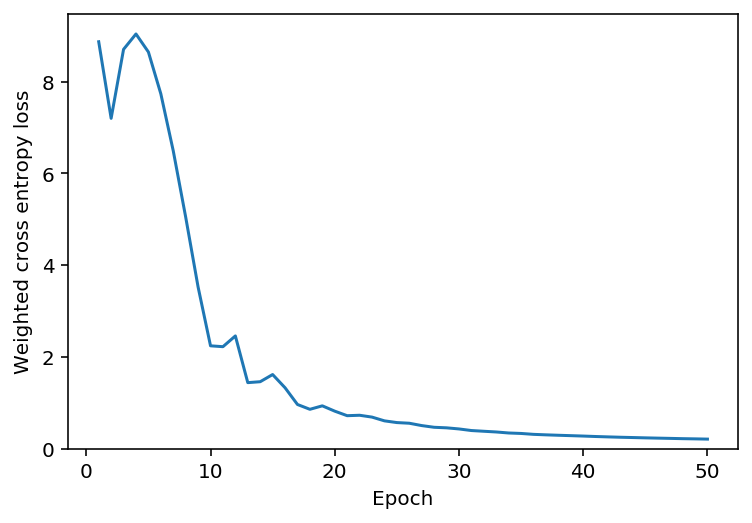

In [12]:
plt.plot(range(1,epochs+1), loss_list1[num_batches-1::num_batches])
plt.xlabel('Epoch')
plt.ylabel('Weighted cross entropy loss')
plt.ylim(0)
plt.show()

In [13]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 12)      120       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      3488      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 2)       578       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 2)       0         
Total params: 4,186
Trainable params: 4,186
Non-trainable params: 0
_________________________________________________________________


### CNN-LSTM

In [14]:
loss_list2 = list()

class SaveBatchLoss2(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        loss_list2.append(logs['loss'])

In [15]:
# check which percentage is particles
num_part = tf.math.reduce_sum(train_labels[:,:,:,:,1])
print(1-num_part/(10*10*128*128))

tf.Tensor(0.9924615478515625, shape=(), dtype=float64)


In [16]:
batch_size = 2
epochs = 50

model2 = Sequential()
model2.add(Input((Nt,128,128,1)))
model2.add(ConvLSTM2D(12, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model2.add(ConvLSTM2D(16, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model2.add(ConvLSTM2D(2, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last', activation="softmax"))

model2.compile(optimizer='adam',
            loss=weightedLoss(keras.losses.categorical_crossentropy, [0.005, 0.995]),
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision_1', class_id=1), 
                      tf.keras.metrics.Recall(name='recall_1', class_id=1), f1_score])

num_batches = int(train_size/batch_size)
model2.fit(train_vid, train_labels, steps_per_epoch=num_batches, epochs=epochs, verbose=1, 
          validation_data=(val_vid, val_labels), callbacks=SaveBatchLoss2())

Epoch 1/50
10/10 [==============================] - 55s 5s/step - loss: 0.0058 - accuracy: 0.7579 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1850 - val_loss: 0.0054 - val_accuracy: 0.9717 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1846
Epoch 2/50
10/10 [==============================] - 40s 4s/step - loss: 0.0049 - accuracy: 0.9551 - precision_1: 0.2108 - recall_1: 0.0244 - f1_score: 0.1843 - val_loss: 0.0043 - val_accuracy: 0.9370 - val_precision_1: 0.1371 - val_recall_1: 0.0786 - val_f1_score: 0.1840
Epoch 3/50
10/10 [==============================] - 39s 4s/step - loss: 0.0039 - accuracy: 0.9259 - precision_1: 0.1022 - recall_1: 0.2380 - f1_score: 0.1838 - val_loss: 0.0040 - val_accuracy: 0.9690 - val_precision_1: 0.1319 - val_recall_1: 0.1964 - val_f1_score: 0.1835
Epoch 4/50
10/10 [==============================] - 39s 4s/step - loss: 0.0037 - accuracy: 0.9412 - precision_1: 0.1082 - recall_1: 0.2912 - f1_score: 0.1834 - val_loss

Epoch 31/50
10/10 [==============================] - 38s 4s/step - loss: 0.0023 - accuracy: 0.9451 - precision_1: 0.3973 - recall_1: 0.4146 - f1_score: 0.2220 - val_loss: 0.0020 - val_accuracy: 0.9843 - val_precision_1: 0.4503 - val_recall_1: 0.3536 - val_f1_score: 0.2224
Epoch 32/50
10/10 [==============================] - 39s 4s/step - loss: 0.0018 - accuracy: 0.9613 - precision_1: 0.3498 - recall_1: 0.5723 - f1_score: 0.2231 - val_loss: 0.0017 - val_accuracy: 0.9500 - val_precision_1: 0.3002 - val_recall_1: 0.6507 - val_f1_score: 0.2241
Epoch 33/50
10/10 [==============================] - 688s 76s/step - loss: 0.0016 - accuracy: 0.9692 - precision_1: 0.3209 - recall_1: 0.6044 - f1_score: 0.2249 - val_loss: 0.0014 - val_accuracy: 0.9665 - val_precision_1: 0.3019 - val_recall_1: 0.6566 - val_f1_score: 0.2257
Epoch 34/50
10/10 [==============================] - 35s 4s/step - loss: 0.0014 - accuracy: 0.9673 - precision_1: 0.2814 - recall_1: 0.6606 - f1_score: 0.2265 - val_loss: 0.0013 -

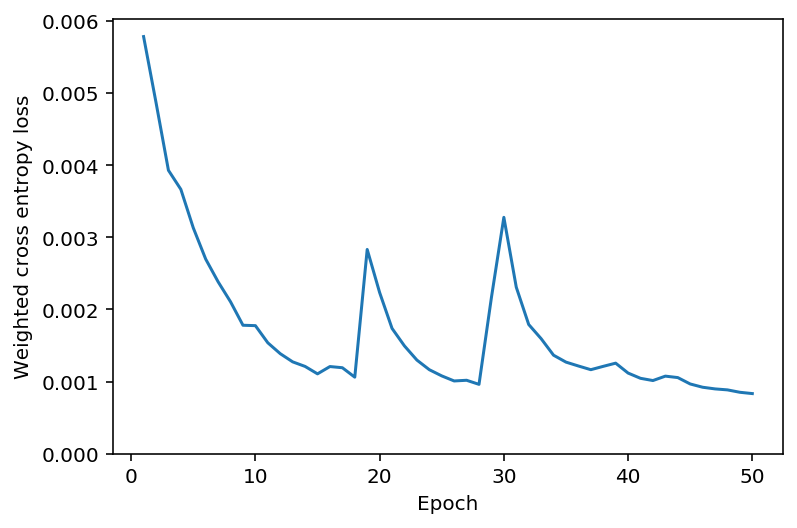

In [17]:
plt.plot(range(1,epochs+1), loss_list2[num_batches-1::num_batches])
plt.xlabel('Epoch')
plt.ylabel('Weighted cross entropy loss')
plt.ylim(0)
plt.show()

In [18]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 128, 128, 12)  5664      
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 128, 128, 16)  16192     
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 128, 128, 2)   1304      
Total params: 23,160
Trainable params: 23,160
Non-trainable params: 0
_________________________________________________________________


### Visualizing the results

In [20]:
Nt = 20
pt_test = Particle_Tracking_Training_Data(Nt)
vid, labels, tracks = pt_test(kappa, a, IbackLevel, Nparticles_det, sigma_motion) 
input_vid = tf.expand_dims(vid[:,::2,::2], 3)

In [21]:
# get model predictions
#pred = model1.predict(input_vid)
pred = model2.predict(tf.expand_dims(input_vid,0))[0]

In [27]:
# convert predictions to binary output
threshold = 0.45
pred_bin = pred.copy()
pred_bin[pred_bin <= threshold] = 0
pred_bin[pred_bin > threshold] = 1

In [28]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(131)
    imshow(vid[t], origin='lower')
    #if show_tracks:
    #    plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(0, 255)
    ylim(0, 255)
    plt.title('Input image', fontsize=25)
        
    fig.add_subplot(132)
    imshow(vid[t], origin='lower')
    imshow(pred_bin[t, ..., 1], origin='lower')
    plt.title('Predicted particles', fontsize=25)
    
    fig.add_subplot(133)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')
    plt.title('Ground truth', fontsize=25)

interactive(children=(IntSlider(value=0, description='t', max=19), Checkbox(value=True, description='show_trac…

# **Tracking the Particles**

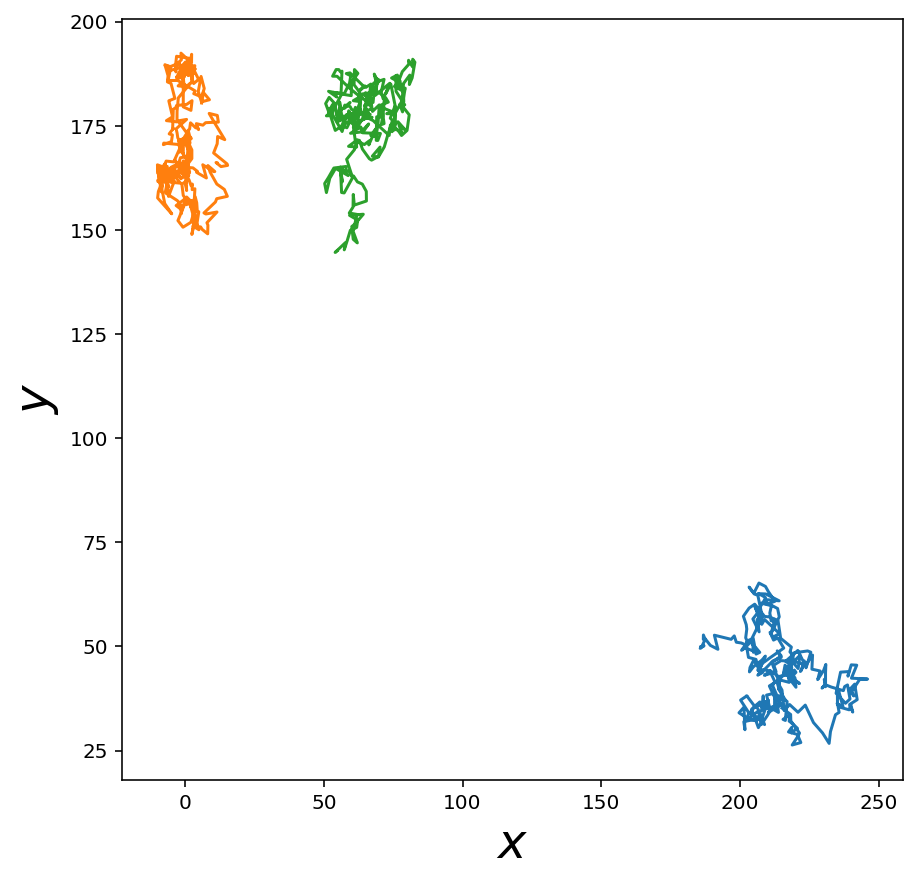

In [9]:
figure(1, [7, 7])
plot(tracks[..., 0], tracks[..., 1])
#xlim(-12, 300)
#ylim(-12, 300)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

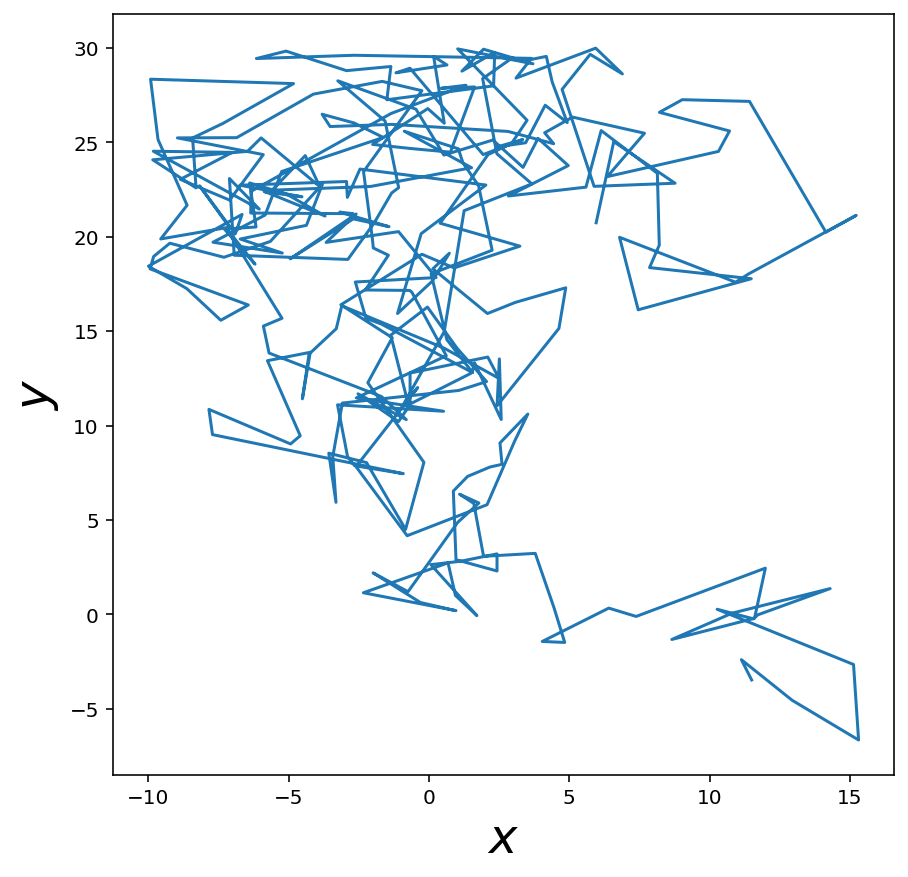

In [11]:
figure(1, [7, 7])
plot(tracks[:,1,0], tracks[:,1,2])
#xlim(-12, 300)
#ylim(-12, 300)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

In [115]:
X=np.array(tracks[:,0,0])
X_scaled=(X-np.mean(X))/np.std(X)
Y=np.array(tracks[:,0,1])
Y_scaled=(Y-np.mean(Y))/np.std(Y)

In [169]:
def get_data(data):
    a_train=[]
    b_train=[]
    for i in range(10,len(data)):
        a_train.append(data[i-10:i])
        b_train.append(data[i])
    a_train, b_train = np.array(a_train), np.array(b_train)
    return(a_train, b_train)

In [170]:
X_train, y_train=get_data(X_scaled[:250])
X_test, y_test=get_data(X_scaled[250:])
Xy_train, yy_train=get_data(Y_scaled[:250])
Xy_test, yy_test=get_data(Y_scaled[250:])

In [247]:
X_train = []
y_train = []
X_train_scaled=X_scaled[:250]
#train_data=train_data.numpy()
for i in range(30,len(X_scaled)):
    X_train.append(X_scaled[i-30:i])
    y_train.append(X_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [248]:
Xy_train = []
yy_train = []
Xy_train_scaled=Y_scaled[:250]
#train_data=train_data.numpy()


In [ ]:
X_test = []
y_test = []

for i in range(30,len(X_scaled)):
    X_train.append(X_scaled[i-30:i])
    y_train.append(X_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))



In [76]:
opt=tf.keras.optimizers.RMSprop(
    learning_rate=0.001
)
model = Sequential()
model.add(CuDNNLSTM(units=32,return_sequences=True, input_shape=(X_train.shape[1],1)))
#model.add(CuDNNLSTM(units=256,return_sequences=True))
#model.add(CuDNNLSTM(units=128,return_sequences=True))
#model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=16,return_sequences=True))
#model.add(CuDNNLSTM(units=32,return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=8,return_sequences=True))
#model.add(CuDNNLSTM(units=8,return_sequences=True))
model.add(CuDNNLSTM(units=4,return_sequences=True))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=opt,loss='mean_squared_error',metrics=["mae"])


In [236]:
model=Sequential()
model.add(CuDNNLSTM(units=128,return_sequences=True, input_shape=(X_train.shape[1],1)) )
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=64,return_sequences=True) )
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=1))
# Compiling the RNN
model.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
#model.fit(X_train,y_train,epochs=50,batch_size=16)
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_136 (CuDNNLSTM)  (None, 10, 128)           67072     
                                                                 
 dropout_59 (Dropout)        (None, 10, 128)           0         
                                                                 
 cu_dnnlstm_137 (CuDNNLSTM)  (None, 10, 64)            49664     
                                                                 
 dropout_60 (Dropout)        (None, 10, 64)            0         
                                                                 
 flatten_37 (Flatten)        (None, 640)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 641       
                                                                 
Total params: 117,377
Trainable params: 117,377
Non-t

In [229]:
model.fit(Xy_train,yy_train,epochs=50,batch_size=16,validation_data=(Xy_test[:2], yy_test[:2]))
y_pred = model.predict(Xy_test)

Epoch 1/50
15/15 [==============================] - 3s 53ms/step - loss: 0.4031 - val_loss: 0.0102
Epoch 2/50
15/15 [==============================] - 0s 15ms/step - loss: 0.2542 - val_loss: 0.0423
Epoch 3/50
15/15 [==============================] - 0s 15ms/step - loss: 0.2598 - val_loss: 0.0292
Epoch 4/50
15/15 [==============================] - 0s 15ms/step - loss: 0.2285 - val_loss: 0.0248
Epoch 5/50
15/15 [==============================] - 0s 15ms/step - loss: 0.2013 - val_loss: 0.0783
Epoch 6/50
15/15 [==============================] - 0s 15ms/step - loss: 0.1704 - val_loss: 0.0443
Epoch 7/50
15/15 [==============================] - 0s 15ms/step - loss: 0.1914 - val_loss: 0.0548
Epoch 8/50
15/15 [==============================] - 0s 15ms/step - loss: 0.1565 - val_loss: 0.0447
Epoch 9/50
15/15 [==============================] - 0s 15ms/step - loss: 0.1754 - val_loss: 0.0519
Epoch 10/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1482 - val_loss: 0.0085
Epoch 11/

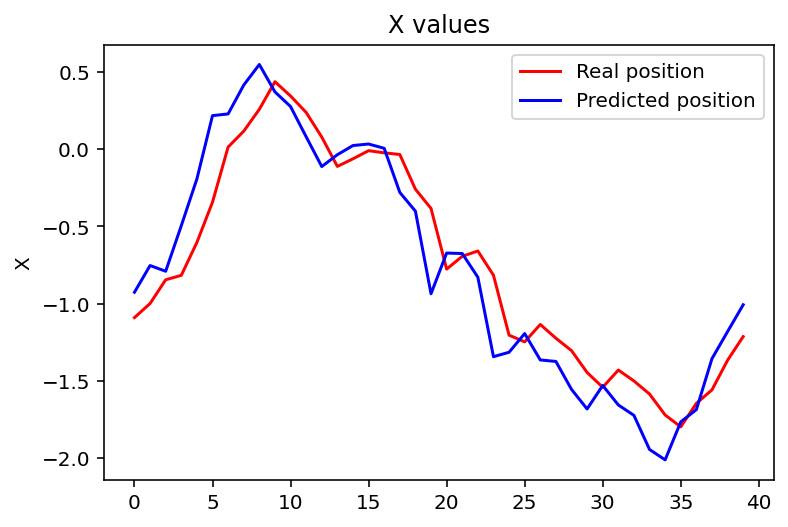

MSE =  0.24164383


In [230]:
plt.plot(y_pred, color='red',label='Real position')
plt.plot(yy_test, color='blue',label='Predicted position');
plt.title('X values')
#plt.xlabel('Date')
plt.ylabel('X')
plt.legend()
plt.show()

MSE1=mean_squared_error(y_pred, yy_test, squared=False)
print("MSE = ", MSE1)


In [231]:
#model.fit(X_train,y_train,epochs=50,batch_size=16, validation_data=(X_test[:2], y_test[:2]))
x_pred = model.predict(X_test)

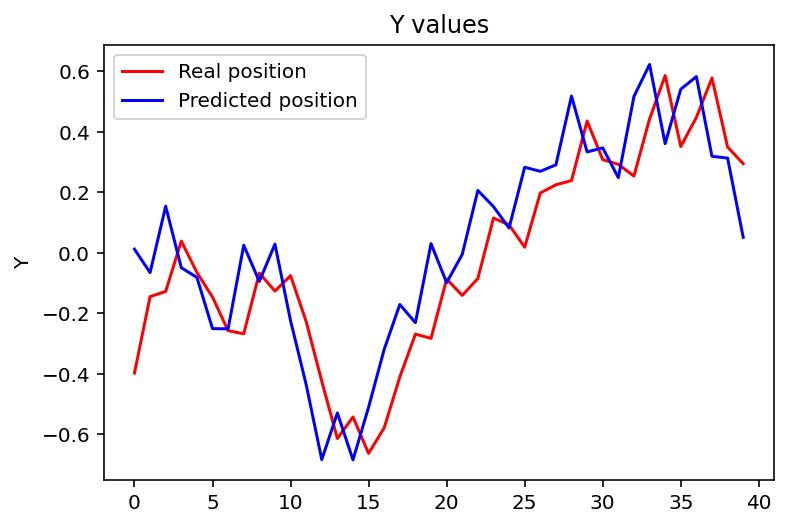

MSE =  0.18714213


In [232]:
plt.plot(x_pred, color='red',label='Real position')
plt.plot(y_test, color='blue',label='Predicted position');
plt.title('Y values')
#plt.xlabel('Date')
plt.ylabel('Y')
plt.legend()
plt.show()

MSE1=mean_squared_error(x_pred, y_test, squared=False)
print("MSE = ", MSE1)

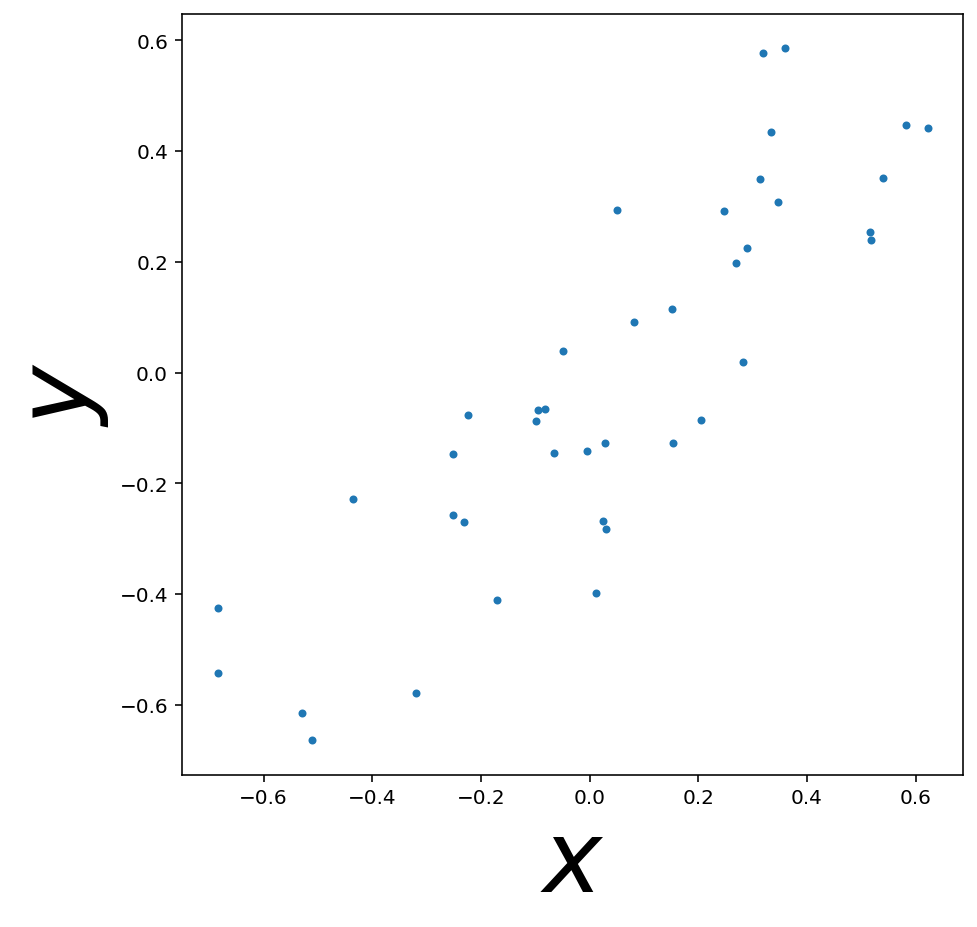

In [233]:
figure(1, [7, 7])
plot(y_test,x_pred,'.')
#xlim(50, 200)
#ylim(50, 200)


xlabel(r'$x$', fontsize=50)
ylabel(r'$y$', fontsize=50);

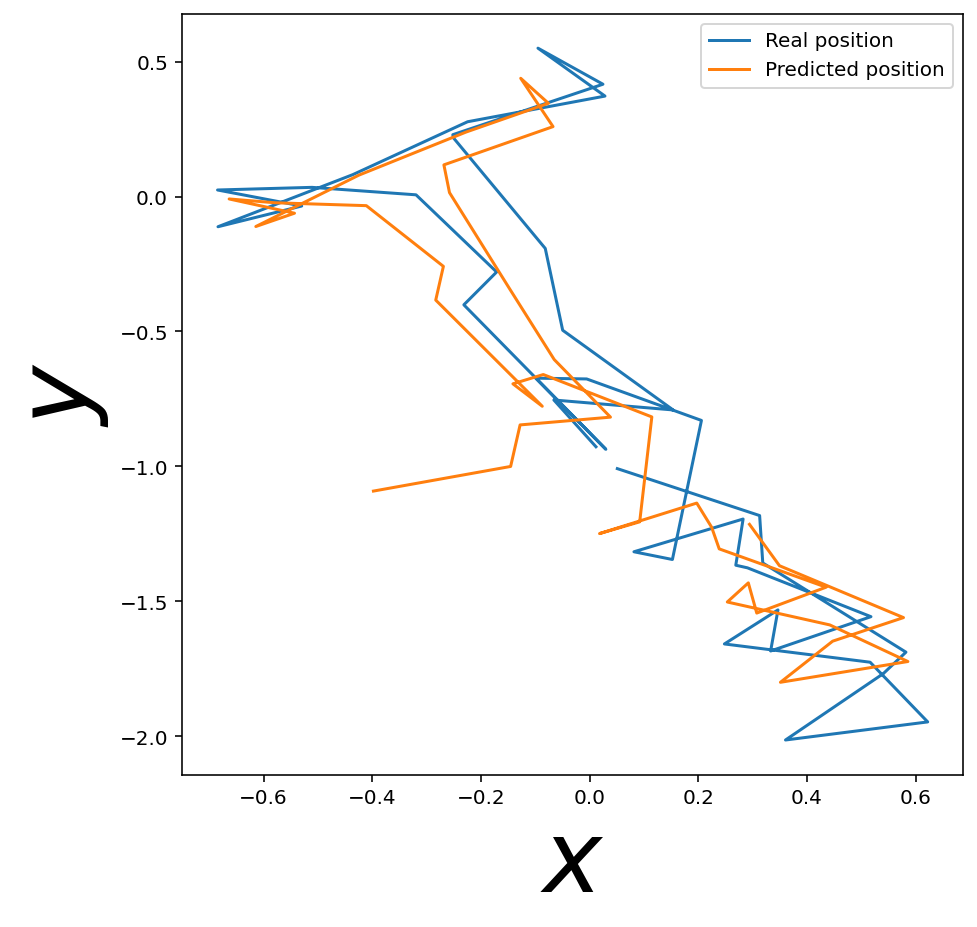

In [234]:
figure(1, [7, 7])
plot(y_test,yy_test,label='Real position')

#xlim(50, 200)
#ylim(50, 200)
plot(x_pred, y_pred,label='Predicted position')
plt.legend()
xlabel(r'$x$', fontsize=50)
ylabel(r'$y$', fontsize=50);

In [235]:
@interact(t=(0, 50-1, 1))
def plotfn(t=0):
    fig = figure(1, [14, 7])
    plot(y_test[:t],yy_test[:t], '--o',label='Real position')
    plot(x_pred[:t], y_pred[:t], '--o',label='Predicted position')
    plt.legend()
    xlabel(r'$x$', fontsize=50)
    ylabel(r'$y$', fontsize=50)
    xlim(-1, 1)
    ylim(-3, 3)

interactive(children=(IntSlider(value=0, description='t', max=49), Output()), _dom_classes=('widget-interact',…